<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/3_First_order_methods/3_12_Conservative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 3: First order methods

# Conservative Steplength Rules

In our previous Section we described how the steplength parameter  $\alpha$ - whether fixed for all iterations or diminishing - is often determined by trial and error when using gradient descent for machine learning and deep learning problems. However because gradient descent is built on such foundational first order ideas we can derive proper steplength parameter settings mathematically.

In this Section we discuss the mathematical framework that provides - essentially regardless of the function being minimized - choices for $\alpha$ that are guaranteed to produce convergence with gradient descent.  However these choices have a few trade-offs. First of all they are often *conservative*, specifically defined to force descent in the function at each step. They also can be computationally expensive depending on the function being minimized and how they are employed. Nonetheless they always provide solutions that work 'out of the box' in almost all situations.

In particular here we will discuss the notions of *backtracking line search* as well as the conservatively optimal fixed steplength defined by what is called a function's *Lipschitz constant*.

In [ ]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone library subdirectory
    if not Path('chapter_3_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/3_First_order_methods/chapter_3_library
    else:
        print('chapter_3_library already cloned!')

    # clone images
    if not Path('chapter_3_images').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/3_First_order_methods/chapter_3_images
    else:
        print('chapter_3_images already cloned!')

    # clone videos
    if not Path('chapter_3_videos').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/3_First_order_methods/chapter_3_videos
    else:
        print('chapter_3_videos already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_3_library')
sys.path.append('./chapter_3_images') 
sys.path.append('./chapter_3_videos') 

# import section helper
import section_3_12_helpers

# image paths
image_path_1 = 'chapter_3_images/Fig_8_1.png'
image_path_2 = 'chapter_3_images/Fig_8_2.png'
image_path_3 = 'chapter_3_images/Fig_8_5.png'
image_path_4 = 'chapter_3_images/exact_vs_backtrack.png'
image_path_5 = 'chapter_3_images/Fig_8_3.png'

# video paths
video_path_1 = 'chapter_3_videos/animation_13.mp4'
video_path_2 = 'chapter_3_videos/animation_14.mp4'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
from base64 import b64encode

def show_video(video_path, width = 1000):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={width} controls><source src="{video_url}"></video>""")

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## Gradient descent and simple quadratic surrogates 

Crucial to the analysis of theoretically convergent steplength parameter choices is the following symmetric quadratic function 

\begin{equation}
h_{\alpha}\left(\mathbf{w}^{\,}\right)=g\left(\mathbf{w}^{0}\right)+\nabla g\left(\mathbf{w}^{0}\right)^{T}\left(\mathbf{w}^{\,}-\mathbf{w}^{0}\right)+\frac{1}{2\alpha}\left\Vert \mathbf{w}^{\,}-\mathbf{w}^{0}\right\Vert _{2}^{2}
\end{equation}

where $\alpha>0$. Notice what precisely this is. The first two terms on the right hand side constitute the *first order Taylor series approximation* to $g(\mathbf{w})$ at a point $\mathbf{w}^0$ or - in other words - the formula for the tangent hyperplane there. The final term on the right hand side is the simplest quadratic component imaginable, turning the tangent hyperplane - regardless of whether or not it is tangent at a point that is locally convex or concave - into a convex and perfectly symmetric quadratic whose curvature is controlled in every dimension by the parameter $\alpha$. Moreover note: like the hyperplane this quadratic is still tangent to the $g(\mathbf{w})$ at $\mathbf{w}^0$, matching both the function and derivative values at this point.

What happens to this quadratic when we change the value of $\alpha$? Below we illustrate the approximation for two different values of $\alpha$ with a generic convex function. Note the connection to $\alpha$:
*the larger the value $\alpha$ the wider the associated quadratic becomes*.

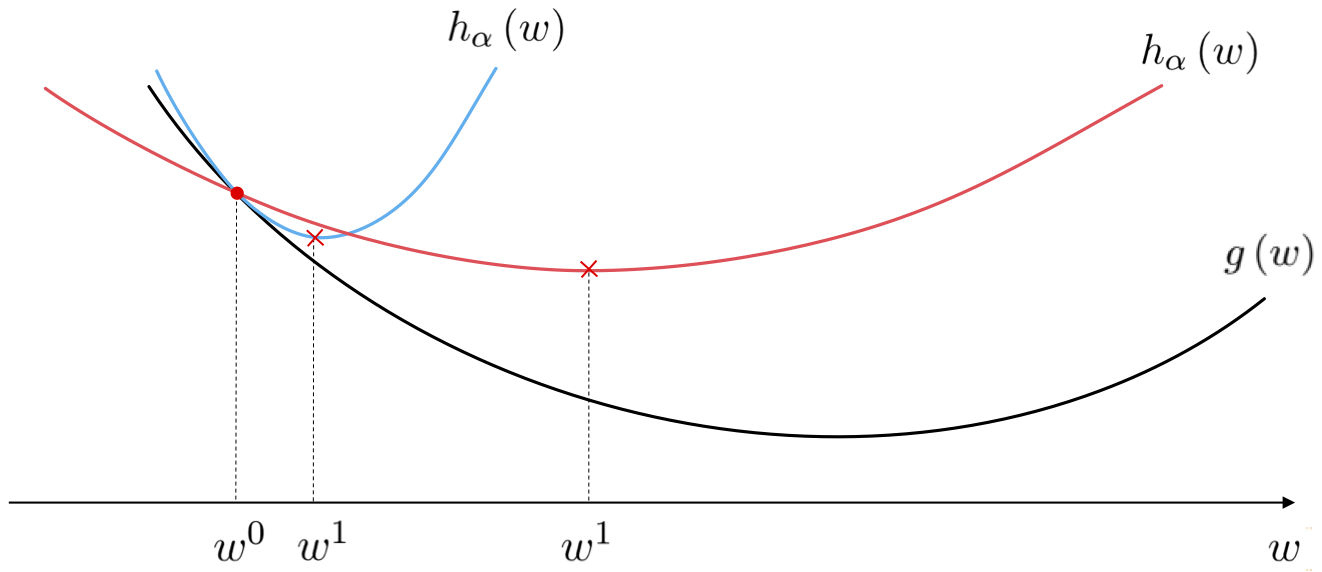

In [3]:
Image(image_path_1, width=600)

<figure>
<figcaption>   
<strong>Figure 1:</strong> <em>Two quadratic functions approximating the function g around $\mathbf{w}^{0}$ given by the quadratic approximation above. The value of $\alpha$ is larger with the red quadratic than with the blue one.</em>  </figcaption> 
</figure>

One of the beautiful things about such a simple quadratic approximation as $h_{\alpha}$ is that we can easily compute a unique global minimum for it, regardless of the value of $\alpha$, by checking the *first order optimality condition* (see [Section 3.2](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_2_First.html)). Setting its gradient to zero we have

\begin{equation}
\nabla h_{\alpha}\left(\mathbf{w}\right)=\nabla g\left(\mathbf{w}^{0}\right)+\frac{1}{\alpha}\left(\mathbf{w}-\mathbf{w}^{0}\right)=\mathbf{0}
\end{equation}

Rearranging the above and solving for $\mathbf{w}$, we can find the minimizer of $h_{\alpha}$, which we call $\mathbf{w}^{1}$, given as 

\begin{equation}
\mathbf{w}^{1}=\mathbf{w}^{0}-\alpha\nabla g\left(\mathbf{w}^{0}\right)
\end{equation}

Thus the minimum of our simple quadratic approximation is precisely a gradient descent step at $\mathbf{w}^{0}$ with a steplength parameter $\alpha$.

If we continue taking steps in this manner the $k^{\textrm{th}}$ update is found as the minimum of the simple quadratic approximation associated with the previous update $\mathbf{w}^{k-1}$, which is likewise

\begin{equation}
h_{\alpha}\left(\mathbf{w}\right)= g\left(\mathbf{w}^{k-1}\right)+ \nabla g\left(\mathbf{w}^{k-1}\right)^{T}\left(\mathbf{w}-\mathbf{w}^{k-1}\right)+\frac{1}{2\alpha}\left\Vert \mathbf{w}-\mathbf{w}^{k-1}\right\Vert _{2}^{2}
\end{equation}

where the minimum is once again given as the $k^{\textrm{th}}$ gradient descent step 

\begin{equation}
\mathbf{w}^{k}=\mathbf{w}^{k-1}-\alpha\nabla g\left(\mathbf{w}^{k-1}\right)
\end{equation}

Thus our exercise with the simple quadratic yields an alternative perspective on the gradient descent algorithm detailed in the previous Section: we can interpret gradient descent as an algorithm that uses linear approximation to move towards a function's minimum, or simultaneously as an algorithm that uses simple quadratic approximations to do the same. In particular this new perspective says that as we move along the direction of steepest descent of the hyperplane, moving from step to step, we are simultaneously 'hopping' down the global minima of these simple quadratic approximations. These two simultaneous perspectives are drawn in the figure below.

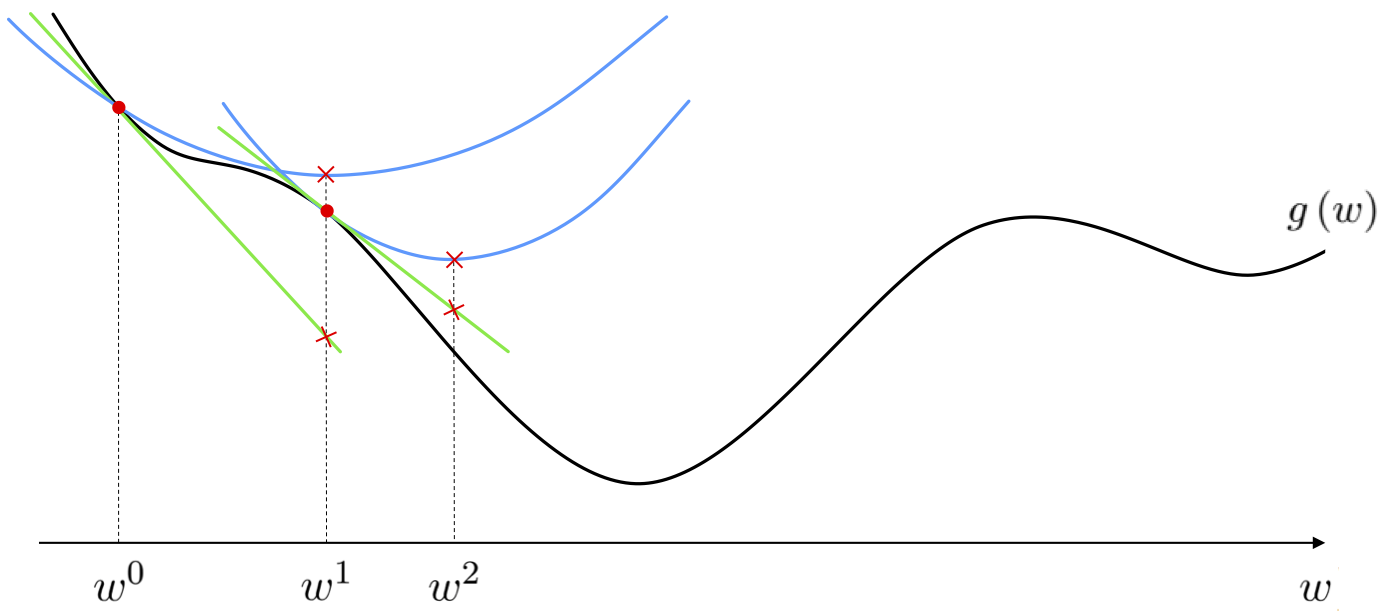

In [5]:
Image(image_path_2, width=600)

<figure>
<figcaption>   
<strong>Figure 2:</strong> <em>Gradient descent can be viewed simultaneously as using either linear or simple
quadratic surrogates to find a stationary point of $g$. At each step
the associated step length defines both how far along the linear surrogate
we move before hopping back onto the function $g$, and at the same
time the width of the simple quadratic surrogate which we minimize
to reach the same point on $g$.</em>
    </figcaption> 
</figure>

This idea is also illustrated for the function $g(w) = \text{cos}(w + 2.5) + 0.1w^2$ below, where moving the slider widget from left to right animates each step of the gradient descent process, as well as both the tangent line and quadratic approximations driving each step.

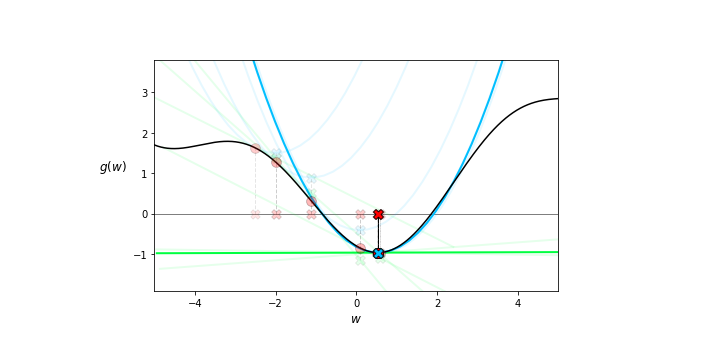

In [6]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.cos(w + 2.5) + 0.1*w**2

# create an instance of the visualizer with this function
demo = section_3_12_helpers.grad_descent_as_quadratic_visualizer(g = g)

# run the visualizer for our chosen input function, initial point, and step length alpha
demo.animate_it(savepath=video_path_1,w_init = -2.5,alpha = 1,max_its = 10,fps=1)

In [8]:
show_video(video_path_1, width=800)

## Backtracking line search

Of course we know that if at a step $\mathbf{w}^{k-1}$ then - if we make $\alpha$ small enough - the gradient descent step to $\mathbf{w}^{k}$ will decrease the value of $g$, i.e., $g\left(\mathbf{w}^{k}\right) \leq g\left(\mathbf{w}^{k-1}\right)$.  Our first perspective on gradient descent tells us that this will work because as we shrink $\alpha$ we are traveling a shorter direction in the descent direction of the tangent hyperplane at $\mathbf{w}^{k-1}$, and if we shrink this distance enough the underlying function should also be decreasing in this direction.  Our second perspective gives us a different but completely equivalent take on this issue: it tells us that in shrinking $\alpha$ we are *increasing* the curvature of the associated quadratic approximation (whose minimum is the point we will move to) so that the *minima of the quadratic approximation lies above the function*. A step to such a point must decrease the function's value because at this point the quadratic is by definition at its lowest, and is in particular lower than where it began tangent to $g$ i.e., at $g\left(\mathbf{w}^{k-1}\right)$.

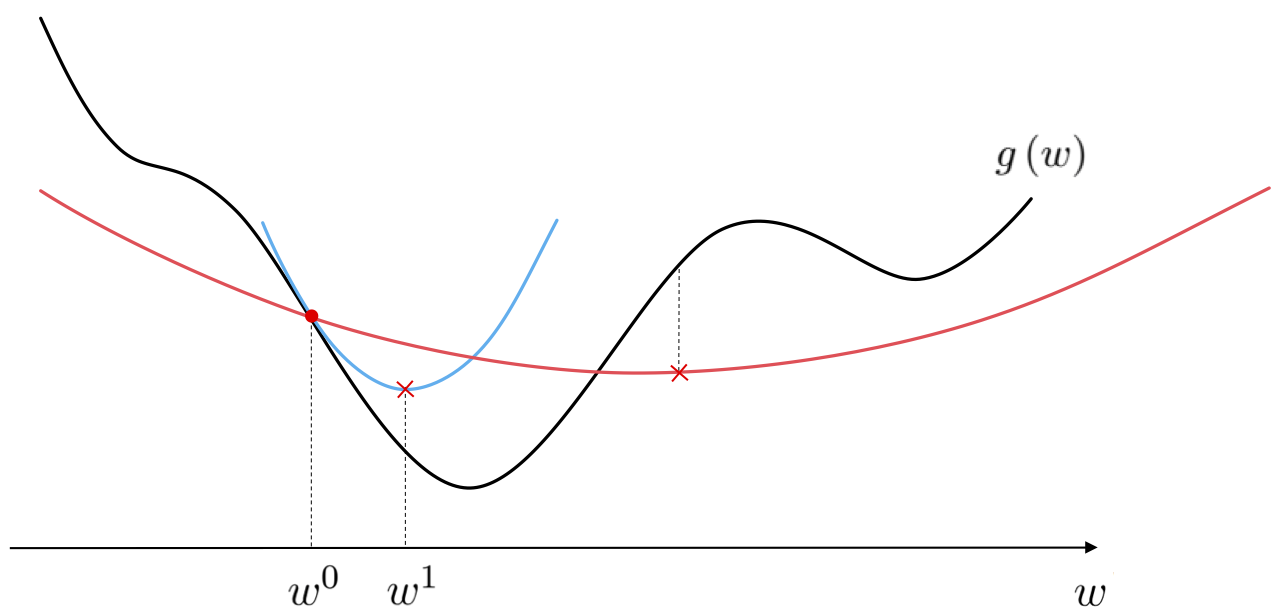

In [10]:
Image(image_path_3, width=600)

<figure>
<figcaption>   
<strong>Figure 3:</strong> <em>An illustration of our second perspective on how to choose a value for the steplength parameter $\alpha$ that is guaranteed to decrease the underlying function's value by taking a single gradient descent step.  The value of $\alpha$ should be decreased until its minimum lies over the function.  A step to such a point must decrease the function's value because at this point the quadratic is by definition at its lowest, and so is in particular lower than where it began tangent to $g$.  Here the $\alpha$ value associated with the red quadratic is too large, while the one associated with the blue quadratic is small enough so that the quadratic lies above the function.  A (gradient descent) step to this point decreases the value of the function $g$.</em>
    </figcaption> 
</figure>

How can we find a value of $\alpha$ that does just this at the point $\mathbf{w}^{k-1}$?  We use the definition of the quadratic approximation there.  If our generic gradient descent step for here is $\mathbf{w}^{k}=\mathbf{w}^{k-1}-\alpha\nabla g\left(\mathbf{w}^{k-1}\right)$, we want to determine a value of $\alpha$ so that at $\mathbf{w}^{k}$ the function is lower than the minimum of the quadratic, i.e., $g\left(\mathbf{w}^{k}\right) \leq h_{\alpha}\left(\mathbf{w}^{k}\right)$.  We could select a large number of values for $\alpha$ and test this condition, keeping the one that provides the biggest decrease.  However this is a computationally expensive and somewhat unwieldy prospect.  Instead we test out values of $\alpha$ via an efficient *bisection* process by which we gradually decrease the value of $\alpha$ from some initial version until the inequality is satisfied.  This procedure - referred to as *backtracking line search* - generally runs as follows.

> **1.**  Choose an initial value for $\alpha$, for example $\alpha = 1$, and a scalar 'dampening factor' $t \in (0,1)$.


> **2.**  Create the candidate descent step $\mathbf{w}^{k}=\mathbf{w}^{k-1}-\alpha\nabla g\left(\mathbf{w}^{k-1}\right)$.


> **3.**  Test if $g\left(\mathbf{w}^{k}\right) \leq h_{\alpha}\left(\mathbf{w}^{k}\right)$.  If yes, then choose $\mathbf{w}^{k}$ as the next gradient descent step, otherwise go to step 4.


> **4.**  Decrease the value of $\alpha$ as $\alpha \longleftarrow t\alpha$ and go back to step 2.

It is the logic of trying out a large value for $\alpha$ first and then decreasing it until we satisfy the inequality that prevents an otherwise unwieldy number of tests to be performed here.  Note however how the dampening factor $t\in (0,1)$ controls how coarsely we sample $\alpha$ values: in setting $t$ closer to $1$ we decrease the amount by which $\alpha$ is shrunk at each failure which could mean more evaluations are required to determine an adequate $\alpha$ value.  Conversely setting $t$ closer to $0$ here shrinks $\alpha$ considerably with every failure, leading to completion more quickly but at the possible cost of outputting a small value for $\alpha$ (and hence a short gradient descent step).

Backtracking line search is a convenient rule for determining a steplength value at each iteration of gradient descent and works 'right out of the box'.  However each gradient step using backtracking line search, compared to using a fixed steplength value, typically includes higher computational cost due to the search for proper step length. 

> Backtracking line search is a convenient rule for determining a steplength value at each iteration of gradient descent and works 'right out of the box'.  However each gradient step using backtracking line search, compared to using a fixed steplength value, typically includes higher computational cost due to the search for proper step length.

### A cleaner rendition of the inequality $g\left(\mathbf{w}^{k}\right) \leq h_{\alpha}\left(\mathbf{w}^{k}\right)$

Before looking at examples and pseudo-code for the backtracking line search scheme, let us take a moment to write the inequality $g\left(\mathbf{w}^{k}\right) \leq h_{\alpha}\left(\mathbf{w}^{k}\right)$ in a more common way that also gives useful insight into the convergence of this method of steplength parameter selection. Plugging in the step  $\mathbf{w}^{k}=\mathbf{w}^{k-1}-\alpha\nabla g\left(\mathbf{w}^{k-1}\right)$ into the quadratic $h_{\alpha}\left(\mathbf{w}^{k}\right)$ we can write it out equivalently (by simplifying and 'completing the square') as 

$$
h_{\alpha}\left(\mathbf{w}^{k}\right) = g\left(\mathbf{w}^{k-1}\right)-\frac{\alpha}{2}\left\Vert \nabla g\left(\mathbf{w}^{k-1}\right)\right\Vert _{2}^{2}
$$

This gives the more insightful version of our desired inequality $g\left(\mathbf{w}^{k}\right) \leq h_{\alpha}\left(\mathbf{w}^{k}\right)$ as

\begin{equation}
g\left(\mathbf{w}^{k}\right)\leq g\left(\mathbf{w}^{k-1}\right)-\frac{\alpha}{2}\left\Vert \nabla g\left(\mathbf{w}^{k-1}\right)\right\Vert _{2}^{2}
\end{equation}

This equivalent version tells us that so long as we have not reached a stationary point of $g$ the term $\frac{\alpha}{2}\left\Vert \nabla g\left(\mathbf{w}^{k-1}\right)\right\Vert _{2}^{2}$ will always be positive, hence finding a value of $\alpha$ that satisfies our inequality means that $g\left(\mathbf{w}^{k}\right)$ will be strictly smaller than $g\left(\mathbf{w}^{k-1}\right)$.

### Backtracking line search algorithm

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>Input:</strong> initial point $\mathbf{w}^{k-1}$, steplength value $\alpha$, and dampening factor $t\in (0,1)$ <br>


<strong>2:</strong>&nbsp;&nbsp; $\mathbf{w}^{k}=\mathbf{w}^{k-1}-\alpha\nabla g\left(\mathbf{w}^{k-1}\right)$<br>

<strong>3:</strong>&nbsp;&nbsp; <code>while</code> $g\left(\mathbf{w}^{k}\right) > g\left(\mathbf{w}^{k-1}\right)-\frac{\alpha}{2}\left\Vert \nabla g\left(\mathbf{w}^{k-1}\right)\right\Vert _{2}^{2}$<br>

<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\alpha \longleftarrow t\alpha$ <br>


<strong>5:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\mathbf{w}^{k}=\mathbf{w}^{k-1}-\alpha\nabla g\left(\mathbf{w}^{k-1}\right)$<br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

#### <span style="color:#a50e3e;">Example 1. </span> Backtracking line search

In the next Python cell we illustrate the use of the backtracking line procedure detailed above to minimize the quadratic function

$$
g\left(w_1,w_2\right) = w_1^2 + 5w_2^2
$$

Starting at the point $(w_1,w_2) = (2,0.5)$ we take 10 descent steps using backtracking line search, with the dampening factor set to $t = 0.8$ and the initial $\alpha = 1$.  This gets us very close to the global minimum  of this function at the origin.  We also plot the result a run of 10 steps using the fixed steplength parameter $\alpha = 0.1$, which does not end at a point nearly as close to the global minimum.

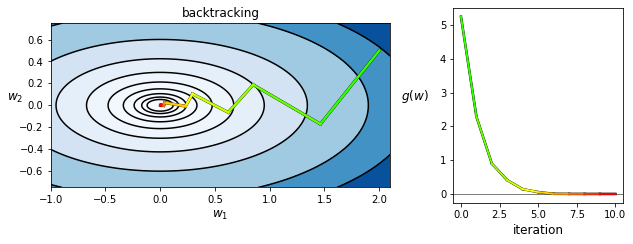

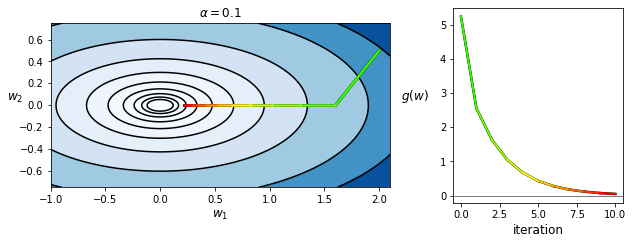

In [11]:
# what function should we play with?  Defined in the next line.
g = lambda w: w[0]**2 + 5*w[1]**2

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = section_3_12_helpers.convservative_steplength_visualizer();
w_init = [2,0.5]; max_its = 10; steplength_vals = ['backtracking',0.1];

demo.run(g,w_init,steplength_vals,max_its,version = 'unnormalized',num_contours = 28,xmin = -1, xmax = 2.1, ymin = -0.75, ymax = 0.75)

## Exact line search

In thinking on how one could automatically adjust the steplength value $\alpha$ at the $\mathbf{w}^{k-1}$ step of gradient descent, one might also think to try determining the steplength $\alpha$ that literally minimizes the function $g$ directly along the $k^{th}$ gradient descent step $\mathbf{w}^{k} = \mathbf{w}^{k-1} - \alpha \nabla g\left(\mathbf{w}^{k-1}\right)$ direction, that is

$$
\underset{\alpha \, > \, 0}{\text{minimize}} \,\,   g\left( \mathbf{w}^{k-1} - \alpha \nabla g\left(\mathbf{w}^{k-1} \right) \right)
$$

This idea is known as *exact line search*.  However practically speaking this must be implemented via a backtracking line search approach much the same way we did above - by successively examining smaller values until we find a value of $\alpha$ at the $k^{th}$ step $\mathbf{w}^{k} = \mathbf{w}^{k-1} - \alpha \nabla g\left(\mathbf{w}^{k-1} \right)$ such that 

$$
g\left(\mathbf{w}^{k} \right) \leq g\left(\mathbf{w}^{k-1}\right)
$$

The problem with this approach in practice is that it can often lead to *large* steps that offer *little* decrease in the function value itself (an issue that we are guarded against with the main backtracking line search method described in this Section due to the convex curvature of the simple quadratic we use to determine when to stop shrinking $\alpha$).

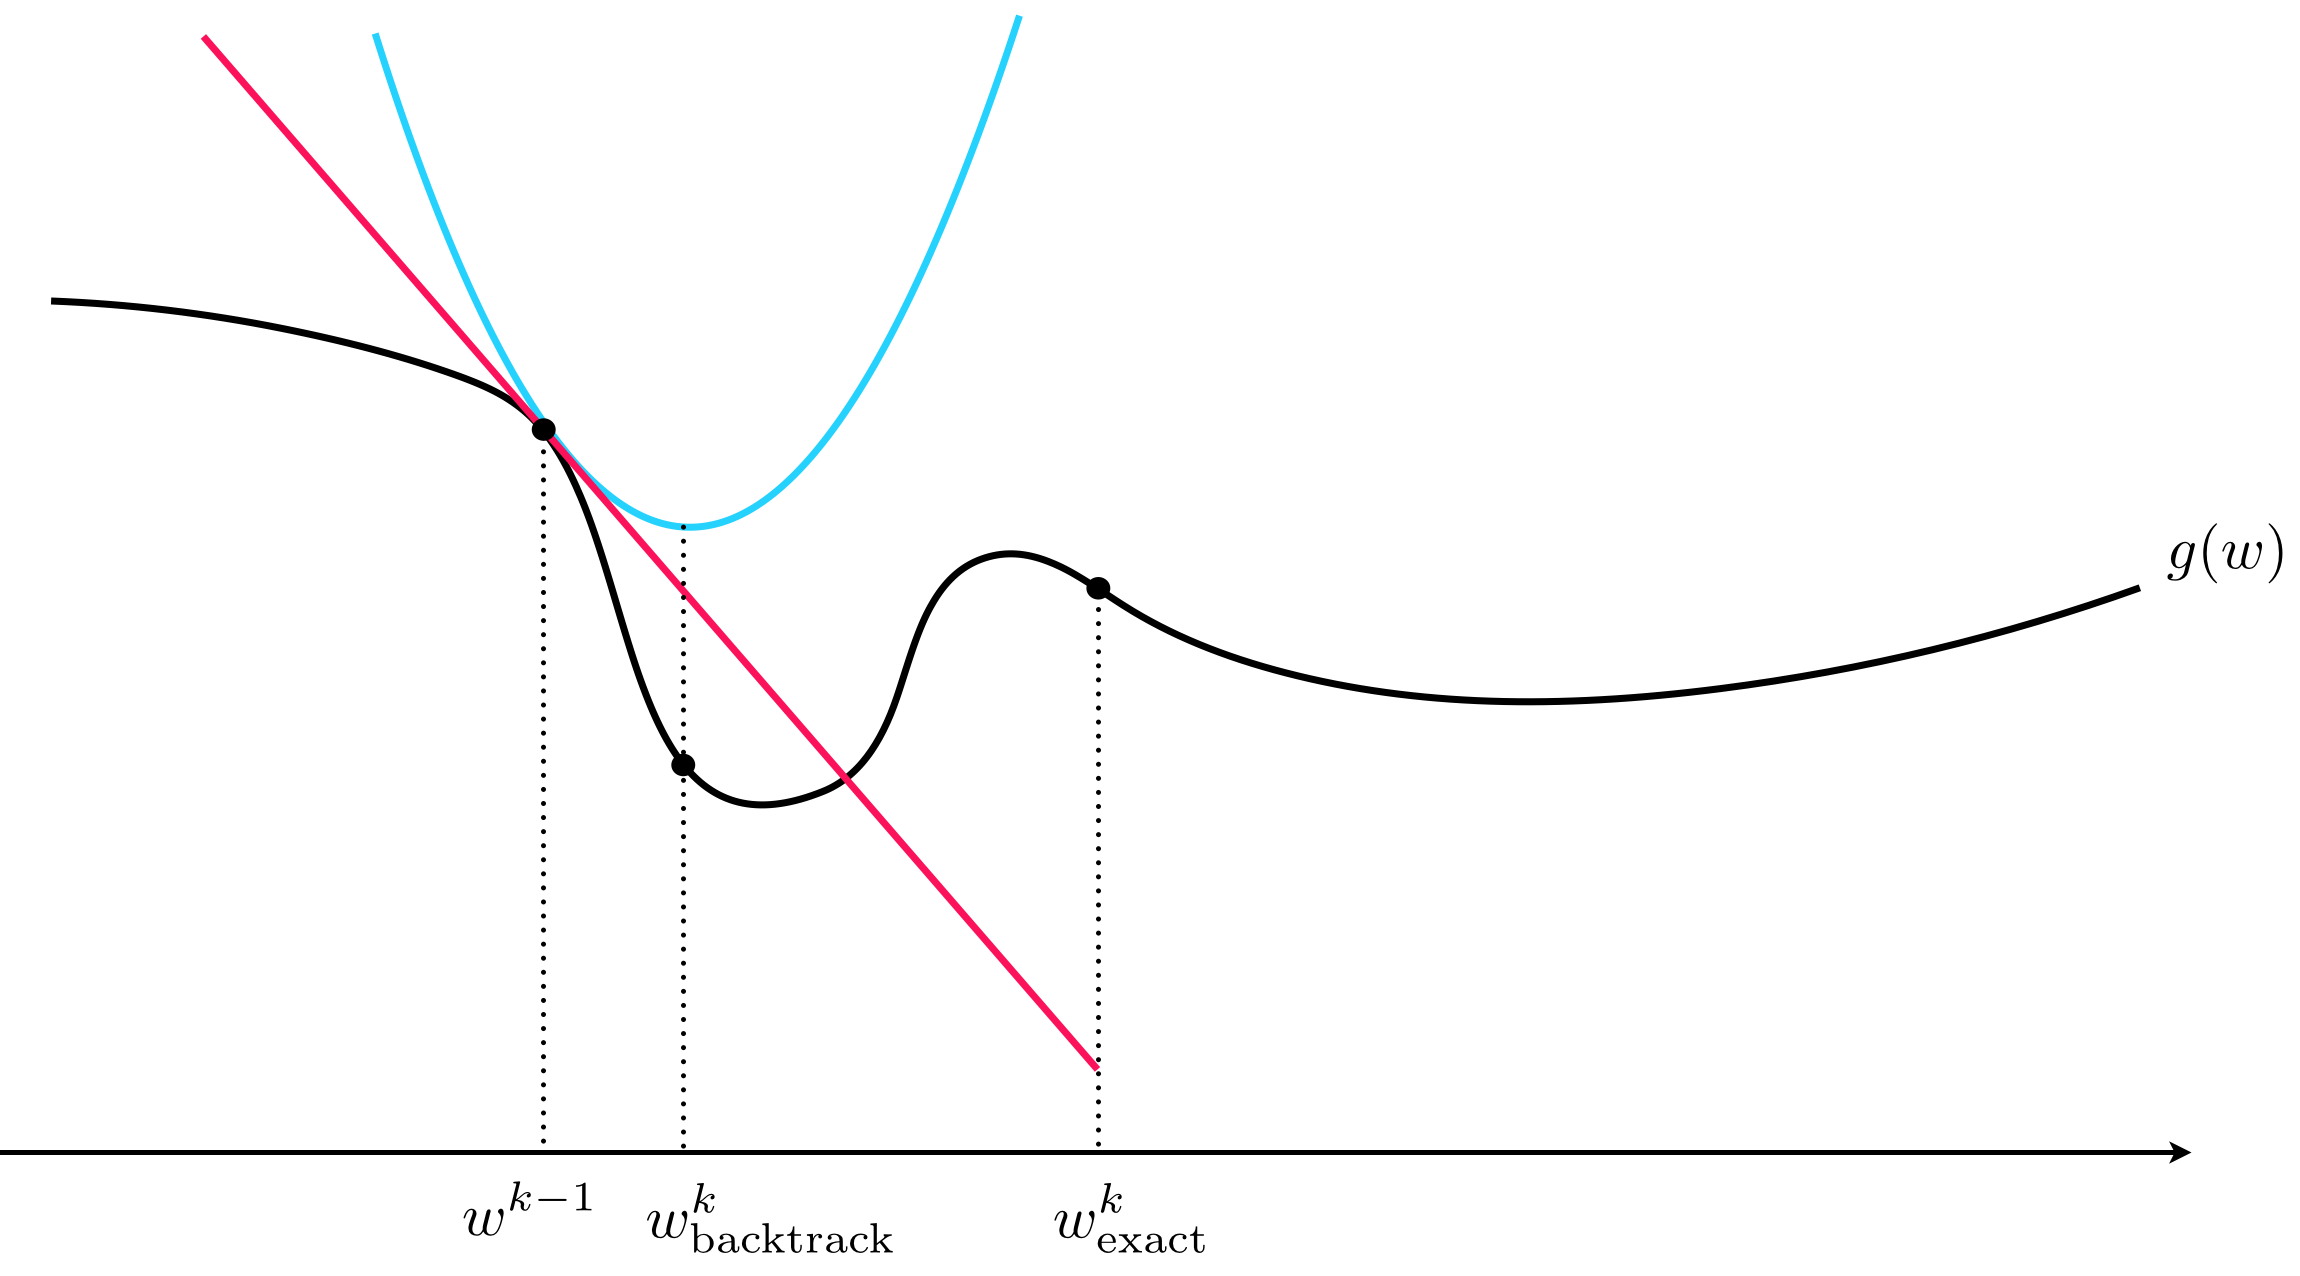

In [13]:
Image(image_path_4, width=600)

<figure>
<figcaption>   
<strong>Figure 4:</strong> <em>With exact line search, unlike the backtracking method, the quadratic associated to gradient descent need not lie entirely above the function $g$ as long as we get a deacrese - however small - in the function evaluation.</em>  </figcaption> 
</figure>

## Conservatively optimal fixed steplength values

Suppose as in the previous Section that we construct the simple quadratic approximation at a point $\mathbf{w}^{k-1}$ for some value of $\alpha$ whose minimum defines the gradient descent step $\mathbf{w}^{k}=\mathbf{w}^{k-1}-\alpha\nabla g\left(\mathbf{w}^{k-1}\right)$.  If we turn up the value of $\alpha$ in the simple quadratic approximation so that it reflects the greatest amount of curvature or change in the function's first derivative - called a function's *Lipschitz constant* - then the *Lipschitz quadratic* approximation will lie completely above the function everywhere except at its point of tangency with the function at $\left(\mathbf{w}^{k-1}, g\left(\mathbf{w}^{k-1}\right) \right)$.  

Since the approximation is convex its minimum at $\mathbf{w}^k$ will of course lie below its point of tangency with the function itself, and since $\alpha$ has been set so that the entire quadratic itself lies above the function this means that in particular this minimum lies above the function.  In other words, our gradient descent step must lead to a smaller evaluation of $g$, i.e., $g\left(\mathbf{w}^{k}\right) < g\left(\mathbf{w}^{k-1}\right)$.

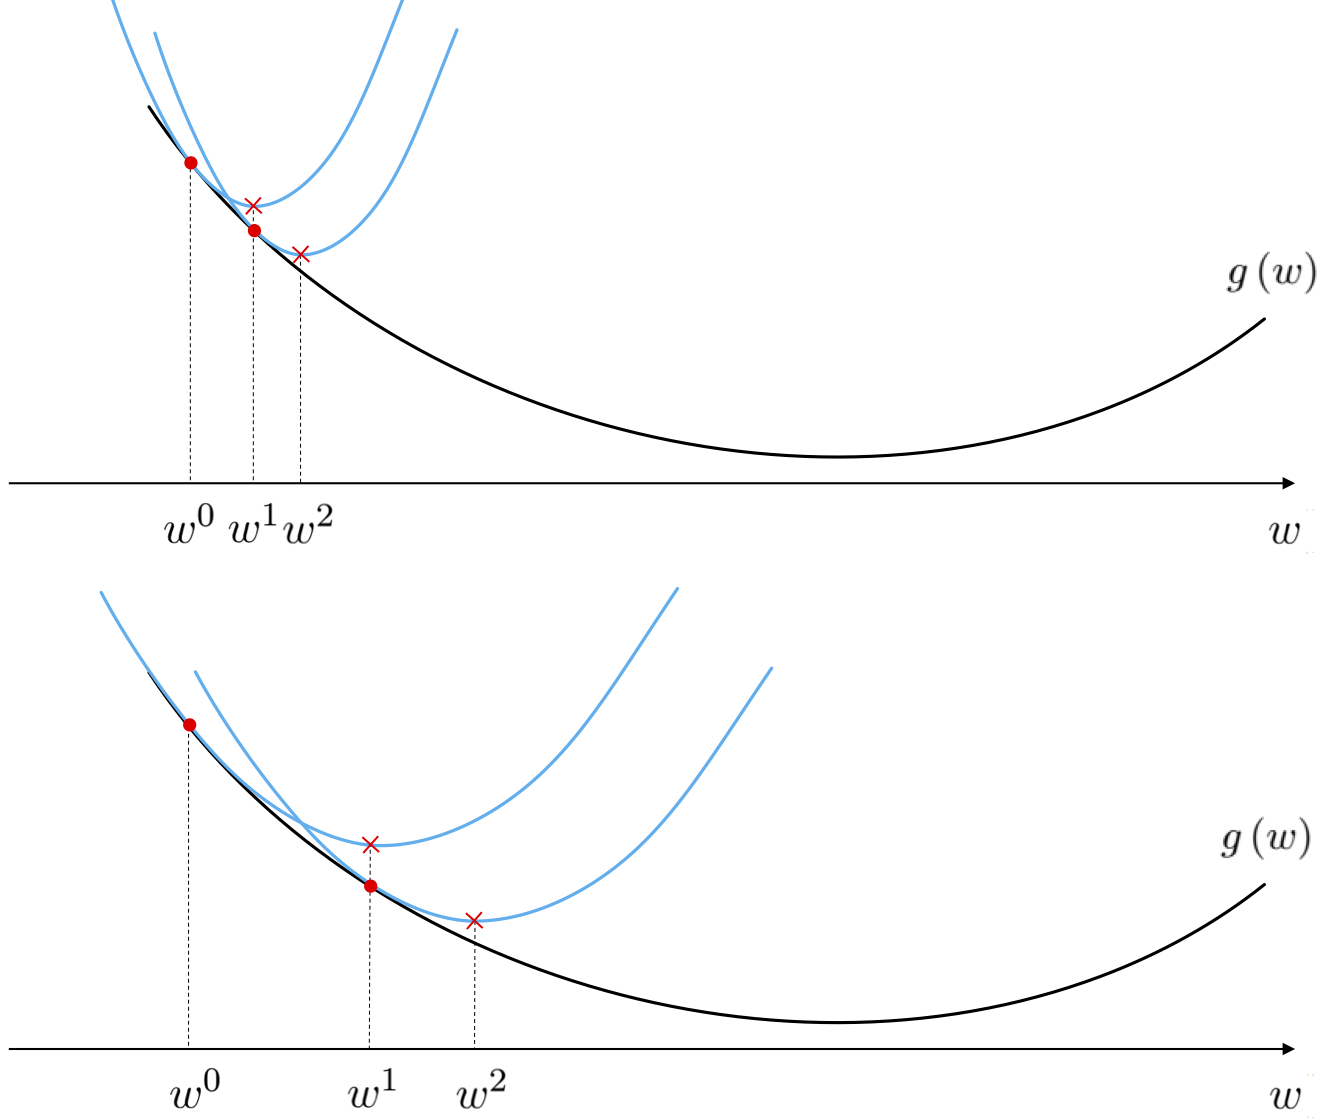

In [15]:
Image(image_path_5, width=600)

<figure>
<figcaption>   
<strong>Figure 5:</strong> <em>(top panel) Too conservative of fixed step length leads to smaller descent steps. (bottom panel) Another conservative fixed step length where the curvature of its associated quadratic just matches the greatest curvature of the hypothetical cost function while still lying entirely above the function. Such a step length is referred to as 'optimally conservative'. Note that while the underlying cost here is drawn convex this applies to non-convex cost functions as well, whose greatest curvature could be negative (on a concave part of the function).</em>
    </figcaption> 
</figure>

#### <span style="color:#a50e3e;">Example 2. </span>  A one dimensional illustration of the Lipschitz quadratic in action

This idea is illustrated for the function $g(w) = \text{sin}(3w) + 0.1w^2 + 1.5$. You can use the slider widget to slide the input point (marked as a red dot) where the quadratic (shown in light blue) is defined (the point of tangency is marked by a red X) back and forth across a portion of this function's input domain. At each point the quadratic approximation is made with the same value of $\alpha$ fixed to the Lipschitz constant of the function, hence its curvature does not change, and it is such that the quadratic always lies completely above the function including its minimum (marked with a green dot along the input axis). The evaluation of this minimum by the function and quadratic approximation are marked with a green and dark blue X respectively.

Notice - by moving the slider back and forth over the entire input domain - how at every point in the function's input domain (except stationary points) the gradient descent step given by the minimum of this quadratic approximation always leads to a smaller value of the function (the red X is always higher on the function than the green one).

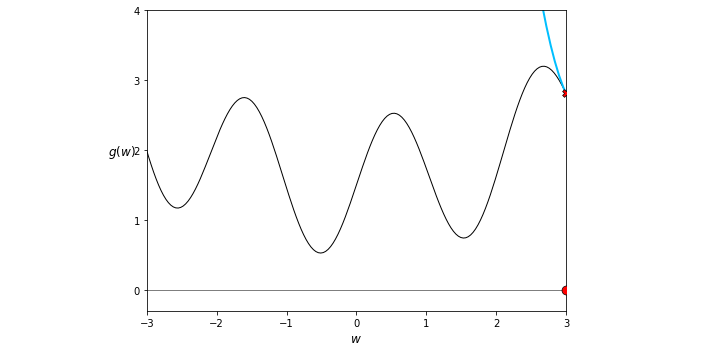

In [16]:
# choose a function 
g = lambda w: np.sin(3*w) + 0.1*w**2 + 1.5

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = section_3_12_helpers.lipschitz_majorizer_visualizer(g=g);

# run it
demo.animate_it(savepath=video_path_2,num_frames = 200,max_val = 3,fps=10)

In [19]:
show_video(video_path_2, width=800)

---

Recall from our discussion of the second derivative in our *vital elements of calculus* series that curvature information of a function is found in its second derivative(s).  More specifically, for a single-input function maximum curvature is defined as the maximum (in absolute value) taken by its second derivative

\begin{equation}
\underset{w}{\text{max}} \,\,   \left|\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w)\right|
\end{equation}

Analogously for a multi-input function $g(\mathbf{w})$ to determine its maximum curvature we must determine the *largest possible eigenvalue (in magnitude) of its Hessian matrix*, i.e., its matrix of second derivatives.  As daunting a task as this may seem it can in fact be done analytically for a range of common machine learning functions such as linear regression, (two-class and multi-class) logistic regression, support vector machines, as well as shallow neural networks.

Once determined this maximum curvature - or an upper bound on it - called $L$ gives a fixed steplength $\alpha = \frac{1}{L}$ that can be used so that the $k^{th}$ descent step $\mathbf{w}^{k} = \mathbf{w}^{k-1} - \frac{1}{L} \nabla g\left(\mathbf{w}^{k-1}\right)$ is guaranteed to always descend in the function $g$.  With this steplength we can initialize gradient descent anywhere in the input domain of a function and gradient descent will converge to a stationary point.  

#### <span style="color:#a50e3e;">Example 3. </span>  Computing the Lipschitz constant of sinusoid

Let us compute the Lipschitz constant - or maximum curvature - of the sinusoid function

$$
g(w) = \text{sin}(w)
$$

We can easily compute the second derivative of this function, which is

$$
\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w) = -\text{sin}(w)
$$

The maximum value this (second derivative) function can take is $1$, hence the Lipschitz constant of $g$ can be set to $L = 1$.

Below we run gradient descent with steplength value $\alpha = \frac{1}{L} = 1$ for 5 iterations, starting from a point near one of its local maxima.  As can be seen in the plot, gradient descent converges very quickly with this choice of steplength value here.

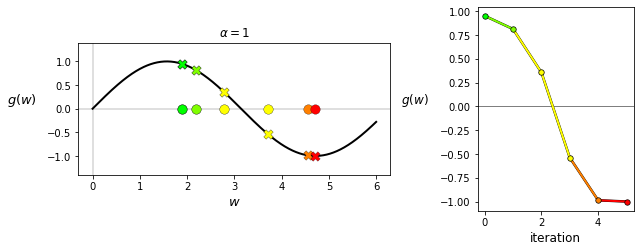

In [20]:
# the Rastrigin function
g = lambda w: np.sin(w)

# run the visualizer for our chosen input function, initial point, and step length alpha
#demo = optlib.convservative_steplength_demos.visualizer();
demo = section_3_12_helpers.convservative_steplength_visualizer();

w_init = np.pi*0.6; max_its = 5; steplength_vals = [1]; version = 'unnormalized';

demo.run(g,w_init,steplength_vals,max_its,version = version,num_contours = 30,linewidth = 2,xmin = 0, xmax = 6)

#### <span style="color:#a50e3e;">Example 4. </span>  Computing the Lipschitz constant of a quadratic in 3d

Now we look at computing the Lipschitz constant of the quadratic function

$$
g(\mathbf{w}) = \mathbf{w}^T \mathbf{A} \mathbf{w}
$$

where $\mathbf{A} = \begin{bmatrix} 2 \,\,\, 0 \\ 0 \,\,\, 1 \end{bmatrix}$.  Here the Hessian is simply $\nabla^2 g(\mathbf{w}) = \mathbf{A}+\mathbf{A}^T=2\mathbf{A}$ for all input $\mathbf{w}$, and since the eigenvalues of a diagonal matrix are precisely its diagonal elements, the maximum (in magnitude) eigenvalue is clearly 4. Thus here we can set the Lipschitz constant to $L = 4$, giving a conservative optimal steplength value of $\alpha = \frac{1}{4}$.  

We show a run of gradient descent on this function with the steplength $\alpha = \frac{1}{4}$ below.  Regardless of where we initialize a gradient descent run, with this steplength it will always converge to the global minimum of the function at the origin.

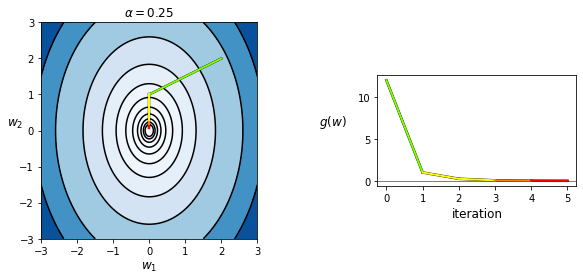

In [21]:
# the Rastrigin function
g = lambda w: 2*w[0]**2 + w[1]**2

# run the visualizer for our chosen input function, initial point, and step length alpha
#demo = optlib.convservative_steplength_demos.visualizer();
demo = section_3_12_helpers.convservative_steplength_visualizer();
w_init = [2,2]; max_its = 5; steplength_vals = [1/float(4)]; version = 'unnormalized';

demo.run(g,w_init,steplength_vals,max_its,version = version,num_contours = 30,linewidth = 2,xmin = -3, xmax = 3,ymin = -3, ymax = 3)

##  Appendix

It is fairly easy to rigorously show that the simple quadratic surrogate tangent to $g$ at $\left(\mathbf{w}^{k-1}, g\left(\mathbf{w}^{k-1}\right) \right)$, with $\alpha=\frac{1}{L}$


\begin{equation}
h_{\frac{1}{L}}\left(\mathbf{w}\right)=g\left(\mathbf{w}^{k-1}\right)+\nabla g\left(\mathbf{w}^{k-1}\right)^{T}\left(\mathbf{w}-\mathbf{w}^{k-1}\right)+\frac{L}{2}\left\Vert \mathbf{w}-\mathbf{w}^{k-1}\right\Vert _{2}^{2}
\end{equation}

where $L$ is the Lipschitz constant for the function $g$, indeed lies completely above the function $g$ at all points. Writing out the first order Taylor's formula for $g$ centered at $\mathbf{w}^{k-1}$,
we have 

\begin{equation}
g\left(\mathbf{w}\right)=g\left(\mathbf{w}^{k-1}\right)+\nabla g\left(\mathbf{w}^{k-1}\right)^{T}\left(\mathbf{w}-\mathbf{w}^{k-1}\right)+\frac{1}{2}\left(\mathbf{w}-\mathbf{w}^{k-1}\right)^{T}\nabla^{2}g\left(\mathbf{c}\right)\left(\mathbf{w}-\mathbf{w}^{k-1}\right)
\end{equation}

where $\mathbf{c}$ is a point on the line segment connecting $\mathbf{w}$
and $\mathbf{w}^{k-1}$. Since $\nabla^{2}g\preceq L\mathbf{I}_{N\times N}$
we can bound the right hand side of the Taylor's formula by replacing
$\nabla^{2}g\left(\mathbf{c}\right)$ with $L\mathbf{I}_{N\times N}$,
giving

\begin{equation}
g\left(\mathbf{w}\right)\leq g\left(\mathbf{w}^{k-1}\right)+\nabla g\left(\mathbf{w}^{k-1}\right)^{T}\left(\mathbf{w}-\mathbf{w}^{k-1}\right)+\frac{L}{2}\Vert\mathbf{w}-\mathbf{w}^{k-1}\Vert_{2}^{2}=h_{\frac{1}{L}}\left(\mathbf{w}\right)
\end{equation}

which indeed holds for all $\mathbf{w}$.